In [1]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib.cm import get_cmap
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = 'Arial'
colors = ['#452a3d', '#44757a', '#b7b5a0', '#eed5b7', '#e5855d', '#dd6c4c', '#d44c3c']

In [2]:
class_width_dict = {'living_street': 0.5,
 'motorway': 1.4,
 'motorway_link': 1.4,
 'primary': 1.1,
 'primary_link': 1.1,
 'residential': 0.5,
 'secondary': 0.9,
 'secondary_link': 0.9,
 'tertiary': 0.7,
 'tertiary_link': 0.7,
 'trunk': 1.3,
 'trunk_link': 1.3,
 'unclassified': 0.5}

In [3]:
def matplot_carbon_itensity(G, eid2ci, id2class, max_ci, min_ci=0.1, log=True, set_lim = False, lims = None):

    cmap = get_cmap('jet').copy()
    gray = "#D3D3D3"
    cmap.set_under(gray)
    cmap.set_over(cmap(1.0))

    if log:
        min_ci = np.log10(min_ci)
        max_ci = np.log10(max_ci)
        eid2ci = {k: np.log10(v) for k, v in eid2ci.items()}

    def getc(ci):
        step = 0.01
        if ci <= min_ci:
            return cmap(0.0)
        elif ci >= max_ci:
            return cmap(1.0)
        else:
            r = (ci - min_ci) / (max_ci - min_ci)
            return cmap(int(r / step) * step) 

    c2eids = defaultdict(list)
    for eid, ci in eid2ci.items():
        c2eids[getc(ci)].append(eid)
    for *_, e in G.edges(data=True):
        if e["id"] not in eid2ci:
            c2eids[gray].append(e["id"])
            
    xmin, ymin, xmax, ymax = G.graph["bound"]
    lx, ly = xmax - xmin, ymax - ymin
    p = 12 / max(lx, ly)
    fig, ax = plt.subplots(figsize=(lx * p, ly * p))
    eid2xys = {e["id"]: e["points_xy"] for *_, e in G.edges(data=True)}
    for c, eids in tqdm(c2eids.items()):
        if c == gray:
            ps = [eid2xys[eid] for eid in eids]
            ax.plot(
            *[vs for xys in ps for vs in zip(*xys)], 
            c=c,
            linewidth = 0.3,
            zorder=0,
            alpha=0.8)
        else:
            for lw in list(set(class_width_dict.values())):
                ps = [eid2xys[eid] for eid in eids if class_width_dict[id2class[eid]] == lw]
                ax.plot(
                *[vs for xys in ps for vs in zip(*xys)], 
                c=c,
                linewidth = lw,
                zorder = 1,
                alpha=0.8)
                
    if log:
        norm = mpl.colors.LogNorm(vmin=10**min_ci, vmax=10**max_ci)
    else:
        norm = mpl.colors.Normalize(vmin=min_ci, vmax=max_ci)

    scalarmap = mpl.cm.ScalarMappable(
        norm=norm,
        cmap=cmap)
    cbar = fig.colorbar(
        scalarmap, 
        ax=ax, 
        extend="both", 
        orientation='horizontal' if lx < ly else "vertical",
        pad=-0.05 if lx < ly else -0.12,
        aspect=35,
        fraction=0.01,
        location="bottom" if lx < ly else "right",
    )

    cbar.set_label(r"CO$_2$ Emission Intensity (g$\cdot$m$^{-1}$)", fontsize=14)

    plt.axis("equal")
    plt.axis("off")
    if set_lim:
        x0, x1, y0, y1= lims
        plt.xlim(xmin + lx * x0, xmin + lx * x1)
        plt.ylim(ymin + ly * y0, ymin + ly * y1)
    plt.tight_layout()
    plt.show()

# Figure 2a-b

C:\Users\ZYK\AppData\Local\Temp\ipykernel_15680\2178161075.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('jet').copy()
100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


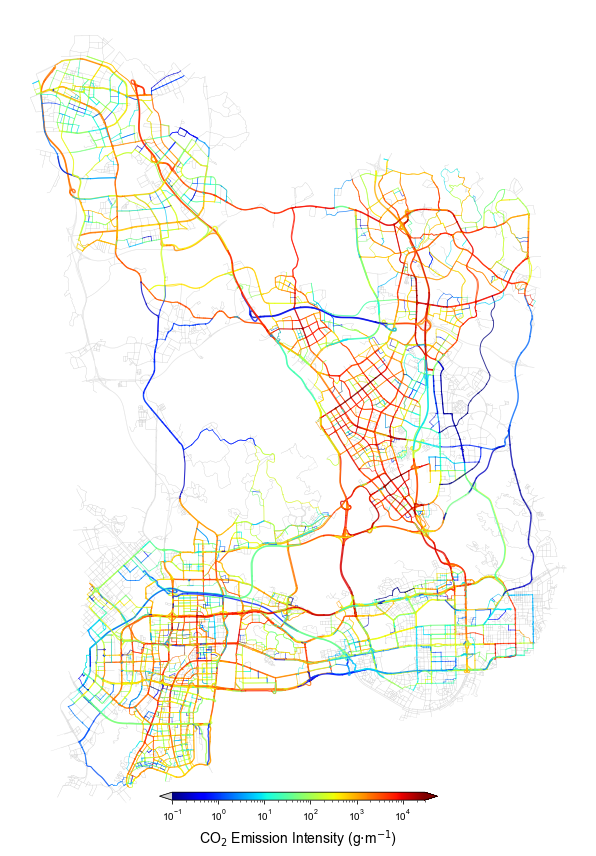

In [4]:
with open('data/sz_spatial.pkl', 'rb') as f:
    G, eid2ci, id2class = pickle.load(f)
matplot_carbon_itensity(G, eid2ci, id2class, max_ci = 30000, log=True)

C:\Users\ZYK\AppData\Local\Temp\ipykernel_15680\2178161075.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('jet').copy()
100%|██████████| 98/98 [00:07<00:00, 13.37it/s]


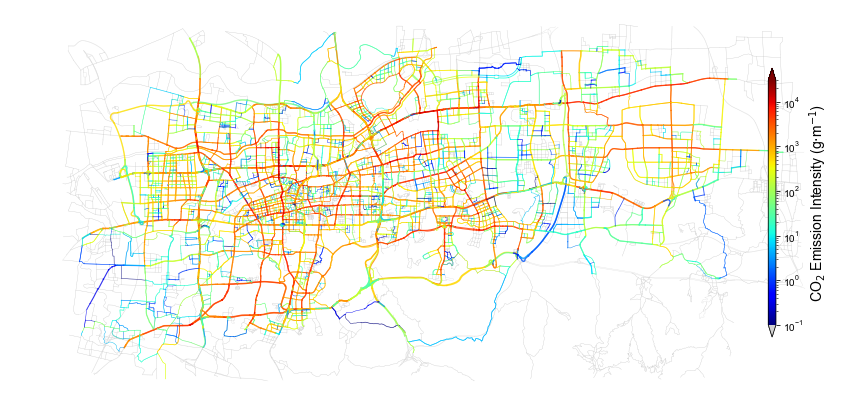

In [5]:
with open('data/jn_spatial.pkl', 'rb') as f:
    G, eid2ci, id2class = pickle.load(f)
matplot_carbon_itensity(G, eid2ci, id2class, max_ci = 30000, log=True)

# Figure 2c-d

In [6]:
## Calculate the average emissions of roads with different levels of Road Hierarchy and Betweenness Centrality

# eid2ci = df_jn1.groupby('RoadID', as_index = False).agg({'Emission': sum, 'RoadLength': np.mean})
# eid2ci1 = df_jn2.groupby('RoadID', as_index = False).agg({'Emission': sum, 'RoadLength': np.mean})
# eid2ci = pd.merge(eid2ci, eid2ci1, on = 'RoadID', how = 'outer').fillna(0)
# eid2ci['Emission'] = eid2ci.Emission_x + eid2ci.Emission_y
# eid2ci['RoadLength'] = np.maximum(eid2ci.RoadLength_x, eid2ci.RoadLength_y)
# eid2ci['Road_level'] = eid2ci.RoadID.map(lambda x: class_width_dict[id2class[x]])
# hier_dict = {0.5: 'residential', 0.7: 'tertiary', 0.9: 'secondary', 1.1: 'primary', 1.3: 'trunk', 1.4: 'trunk'}
# eid2ci['Road_level1'] = eid2ci.Road_level.map(lambda x: hier_dict.get(x))
# eid2ci['Centrality'] = eid2ci.RoadID.map(lambda x: eb1[x])
# eid2ci['Centrality_level'] = pd.qcut(eid2ci['Centrality'], 5, labels = [0,1,2,3,4])
# eid2ci['Intensity'] = eid2ci['Emission'] / eid2ci['RoadLength']
# for i, lev in enumerate([0,1,2,3,4]): 
#     m, intv, moe = calc_95(eid2ci[eid2ci.Centrality_level == lev].Intensity)

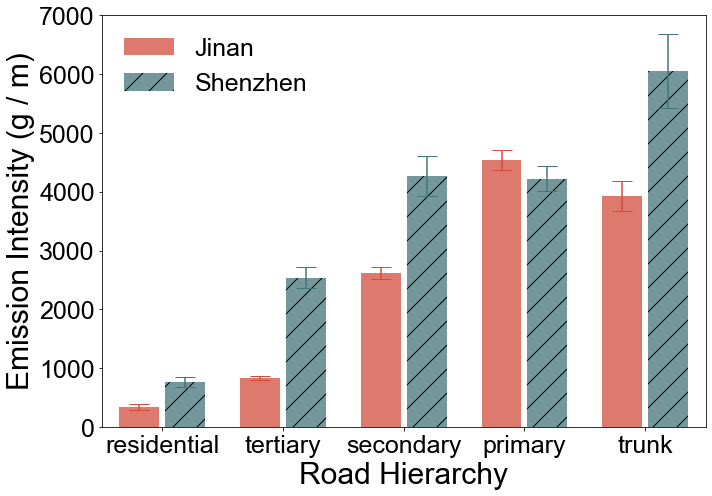

In [7]:
# Here shows the average value and 95% CIs of average emissions for each level
res = [[335.68840968340396, 45.44044719237799],
[830.2097516669972, 41.76192791041514],
[2620.486498421368, 101.73059321180843],
[4541.927996160558, 164.5668391910975],
[3926.8631533867047, 248.2905097131114]]

res1 = [[760.2902900170211, 82.52794159995894],
[2538.225204899873, 176.71320189800653],
[4269.015823962992, 344.1217658519239],
[4222.048540971879, 212.7721525629654],
[6051.978792036062, 627.5437018456822]]

fig, ax = plt.subplots(figsize = (10, 7))
l = len(res)
plt.bar([i-0.19 for i in range(l)], [r[0] for r in res], width = 0.33, color = colors[6], alpha = 0.75, yerr=[r[1] for r in res], capsize=10, ecolor = colors[6], label = 'Jinan')
plt.bar([i+0.19 for i in range(l)], [r[0] for r in res1], width = 0.33, color = colors[1], alpha = 0.75, yerr=[r[1] for r in res1], capsize=10, ecolor = colors[1], label = 'Shenzhen', hatch = '/')

plt.xlim(-0.5, 4.5)
plt.ylabel('Emission Intensity (g / m)', size = 30)
plt.xlabel('Road Hierarchy', size = 30)
plt.xticks(range(5), ['residential', 'tertiary', 'secondary', 'primary', 'trunk'], size = 25)
plt.yticks(range(0, 7001, 1000), size = 25)
plt.legend(frameon = False, fontsize = 25)
plt.tight_layout()
plt.show()

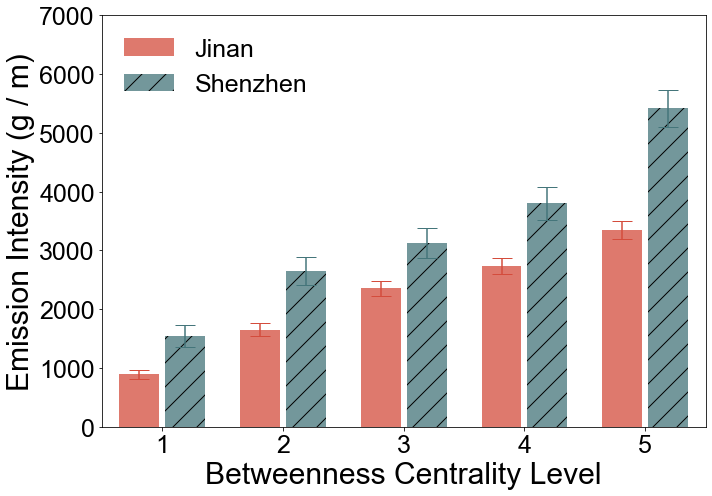

In [8]:
res = [[892.3776298790235, 77.40451406340914],
[1654.8901751497483, 110.26955256744067],
[2356.587969495366, 129.98806397833891],
[2737.738484674538, 132.47046024276264],
[3348.782140341652, 145.37040360633483]]

res1 = [[1546.253566398076, 183.43734568740854],
[2646.101342207018, 236.21896449639516],
[3128.6116799877705, 257.6102699917979],
[3805.0597969342, 282.0239361840435],
[5416.63841497984, 310.7297158937999]]

fig, ax = plt.subplots(figsize = (10, 7))
l = len(res)
plt.bar([i-0.19 for i in range(l)], [r[0] for r in res], width = 0.33, color = colors[6], alpha = 0.75, yerr=[r[1] for r in res], capsize=10, ecolor = colors[6], label = 'Jinan')
plt.bar([i+0.19 for i in range(l)], [r[0] for r in res1], width = 0.33, color = colors[1], alpha = 0.75, yerr=[r[1] for r in res1], capsize=10, ecolor = colors[1], label = 'Shenzhen', hatch = '/')

plt.xlim(-0.5, 4.5)
plt.ylabel('Emission Intensity (g / m)', size = 30)
plt.xlabel('Betweenness Centrality Level', size = 30)
plt.xticks(range(5), range(1, 6), size = 25)
plt.yticks(range(0, 7001, 1000), size = 25)
plt.legend(frameon = False, fontsize = 25)
plt.tight_layout()
plt.show()

# Figure 2e

In [9]:
## GWR
# gwr_selector = Sel_BW(coords, y, X)
# gwr_bw = gwr_selector.search(bw_min = 20.0)
# gwr_model = GWR(coords, y, X, gwr_bw)
# gwr_results = gwr_model.fit()
# for i, name in enumerate(variables):
#     gdf['gwr_' + name] = gwr_results.params[:, i]

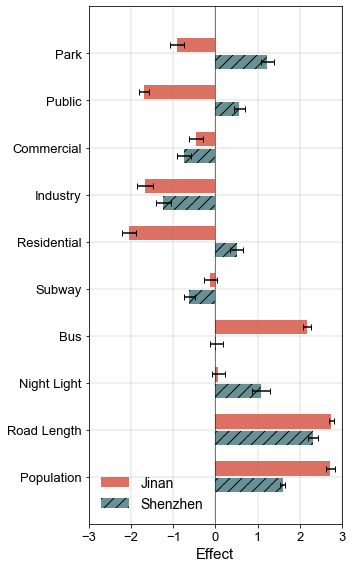

In [10]:
with open('data/gwr_effects.pkl', 'rb') as f:
    ms, ss = pickle.load(f)

sfeats2 = ['Population', 'Road Length', 'Night Light', 'Bus', 'Subway', 'Residential', 'Industry', 'Commercial', 'Public', 'Park']
new_order = ['logpop', 'rlen', 'light', 'bus', 'subway', 'land2-住宅', 'land2-工业',
       'land2-商业', 'land2-公共', 'land2-绿地']

index = np.arange(len(ms[0]))
bar_width = 0.3
fig, ax = plt.subplots(figsize = (5, 8))
plt.ylim(-1, len(ms[0]))
plt.vlines(0, -1, len(ms[0]), lw = 0.5, color = 'black')
plt.barh(index+0.175, ms[1][new_order], bar_width, color = colors[-1], xerr=ss[1][new_order], alpha = 0.8, capsize=3, label = 'Jinan')
plt.barh(index-0.175, ms[0][new_order], bar_width, color = colors[1], xerr=ss[0][new_order], alpha = 0.8, capsize=3, label = 'Shenzhen', hatch = '//')
plt.xlabel('Effect', size = 15)
plt.xticks(size = 13)
plt.yticks(index, sfeats2, size = 13) 
plt.legend(fontsize = 14, frameon = False)
ax.grid(which='major', linestyle='-', linewidth='0.25', color='gray')
plt.xlim(-3, 3)
plt.tight_layout()
plt.show()